this notebook trys to visulize neurons using keras-vis.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import os.path
import numpy as np

from skimage.io import imsave

In [2]:
from tang_jcompneuro import dir_dictionary

In [3]:
model_save_dir = os.path.join(dir_dictionary['models'], 'cnn_cherrypick', 'MkA_all_0_b4')

In [4]:
from keras import layers, models
from keras import backend as K
# you must do this. otherwise keras-vis may get screwed up.
K.set_image_data_format('channels_first')

Using TensorFlow backend.


In [5]:
def load_one_keras_model(torch_model_grp: dict):
    # follow https://github.com/keras-team/keras/blob/master/keras/applications/vgg16.py
    num_channel = torch_model_grp['conv.conv0.weight'].shape[0]
    input_this = layers.Input(shape=(1,20,20))
    print(torch_model_grp['conv.conv0.weight'].transpose(2,3,1,0).shape)
    x = layers.Conv2D(num_channel, (9,9), activation='relu', padding='valid', data_format='channels_first',
                     kernel_initializer=lambda x: torch_model_grp['conv.conv0.weight'].transpose(2,3,1,0),
                      bias_initializer=lambda x: torch_model_grp['conv.conv0.bias'],
                      name='conv')(input_this)
    x = layers.MaxPooling2D((6,6),strides=(2,2),name='pool',data_format='channels_first')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(1,
                     kernel_initializer=lambda x: torch_model_grp['fc.fc.weight'].T,
                     bias_initializer=lambda x: torch_model_grp['fc.fc.bias'],
                     name='fc'
                    )(x)
    return models.Model(input_this, x, name=f'b.{num_channel}')
    

In [6]:
# neuron_to_work_on = 4

In [7]:
def load_one_model(neuron_idx):
    with h5py.File(os.path.join(model_save_dir,
                                f'{neuron_idx}.hdf5'), 'r') as f_out:
        data_dict = {
            x: f_out[f'model/{x}'][...] for x in ('conv.conv0.weight', 'conv.conv0.bias',
                                                  'fc.fc.weight', 'fc.fc.bias')
        }
        
        
        return load_one_keras_model(data_dict), f_out['ytest_hat'][...], f_out['corr'][()]
    


In [8]:
from tang_jcompneuro.io import load_split_dataset, load_image_dataset

In [9]:
# check that it can predict our model.
def load_data(neuron_idx):
    datasets_local = load_split_dataset('MkA_Shape', 'all', True, neuron_idx)
    return datasets_local


In [10]:
from vis.visualization import visualize_activation
from vis.utils import utils

In [11]:
plot_save_dir = os.path.join(dir_dictionary['plots'], 'main', 'demo_fitted_neurons')
assert os.path.exists(plot_save_dir)

In [12]:
def do_one_case(neuron_to_work_on):
    model_this, ytest_hat, corr = load_one_model(neuron_to_work_on)
    print(model_this.summary())
    
    datasets = load_data(neuron_to_work_on)
    ytest_hat_debug = model_this.predict(datasets[2])
    assert ytest_hat.shape == ytest_hat_debug.shape
    assert abs(ytest_hat-ytest_hat_debug).max() < 1e-3
    print(neuron_to_work_on, corr)
    
    layer_idx = utils.find_layer_idx(model_this, 'fc')
    
    images_all = []
    images_all_inverted = []
    
    for _ in range(5):
        np.random.seed(_)
        img = visualize_activation(model_this, layer_idx, filter_indices=0,
                                           tv_weight=0.2,lp_norm_weight=0.1,input_range=(-1.0,1.0))
        img = np.broadcast_to((img+1)/2, shape=(20,20,3))
        images_all.append(img)
        images_all_inverted.append(1-img)
        
        plt.close('all')
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.subplot(1,2,2)
        plt.imshow(1-img)
        plt.show()
    img_final = utils.stitch_images(images_all, cols=5, margin=5)
    img_final = np.pad(img_final, [(5,5),(5,5),(0,0)], mode='constant')
    
    img_final_inverted = utils.stitch_images(images_all_inverted, cols=5, margin=5)
    img_final_inverted = np.pad(img_final_inverted, [(5,5),(5,5),(0,0)], mode='constant')
    
    imsave(os.path.join(plot_save_dir, f'{neuron_to_work_on}.png'), img_final)
    imsave(os.path.join(plot_save_dir, f'{neuron_to_work_on}_inverted.png'), img_final_inverted)

(9, 9, 1, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 20, 20)         0         
_________________________________________________________________
conv (Conv2D)                (None, 4, 12, 12)         328       
_________________________________________________________________
pool (MaxPooling2D)          (None, 4, 4, 4)           0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
fc (Dense)                   (None, 1)                 65        
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________
None
4 0.780784


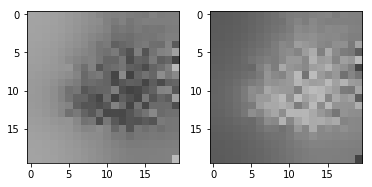

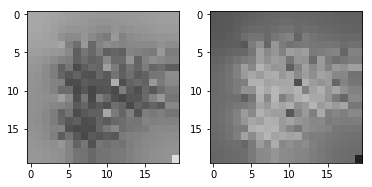

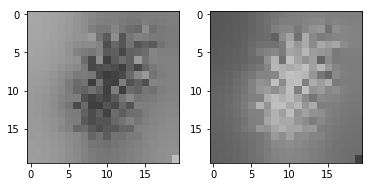

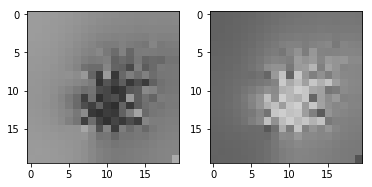

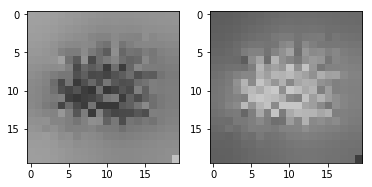

/home/yimengzh/miniconda2/envs/tf15/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(9, 9, 1, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 20, 20)         0         
_________________________________________________________________
conv (Conv2D)                (None, 4, 12, 12)         328       
_________________________________________________________________
pool (MaxPooling2D)          (None, 4, 4, 4)           0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
fc (Dense)                   (None, 1)                 65        
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________
None
459 0.809834


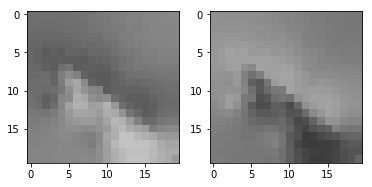

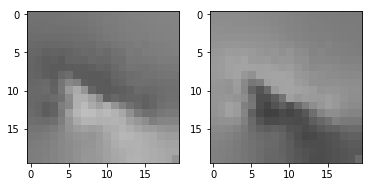

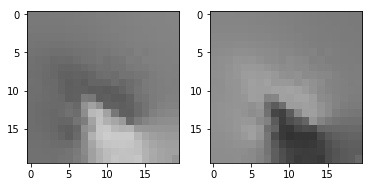

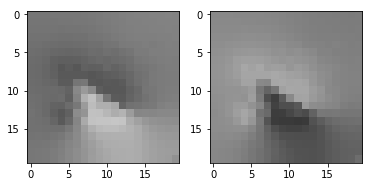

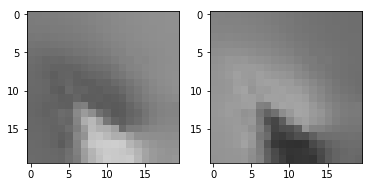

(9, 9, 1, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 20, 20)         0         
_________________________________________________________________
conv (Conv2D)                (None, 4, 12, 12)         328       
_________________________________________________________________
pool (MaxPooling2D)          (None, 4, 4, 4)           0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
fc (Dense)                   (None, 1)                 65        
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________
None
578 0.831387


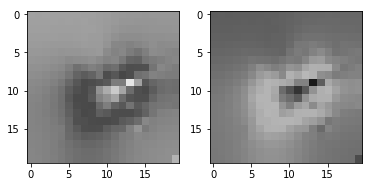

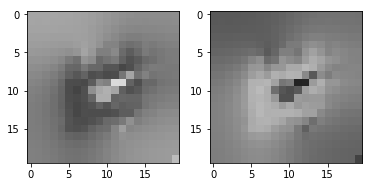

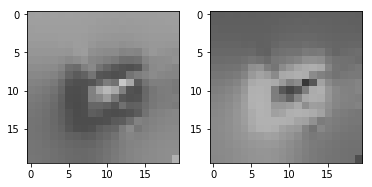

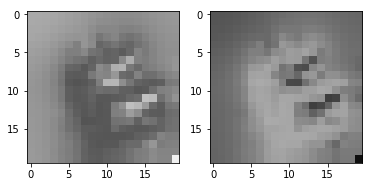

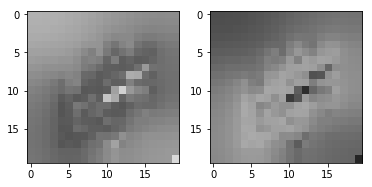

(9, 9, 1, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1, 20, 20)         0         
_________________________________________________________________
conv (Conv2D)                (None, 4, 12, 12)         328       
_________________________________________________________________
pool (MaxPooling2D)          (None, 4, 4, 4)           0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
fc (Dense)                   (None, 1)                 65        
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________
None
1079 0.694351


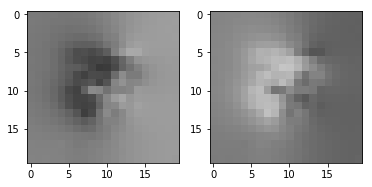

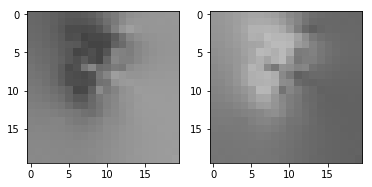

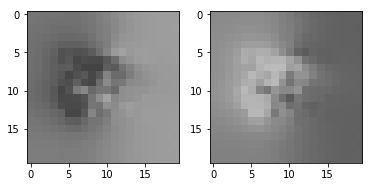

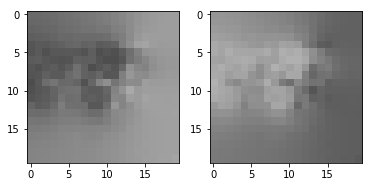

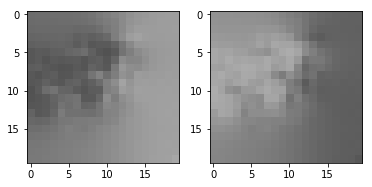

(9, 9, 1, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1, 20, 20)         0         
_________________________________________________________________
conv (Conv2D)                (None, 4, 12, 12)         328       
_________________________________________________________________
pool (MaxPooling2D)          (None, 4, 4, 4)           0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
fc (Dense)                   (None, 1)                 65        
Total params: 393
Trainable params: 393
Non-trainable params: 0
_________________________________________________________________
None
553 0.659673


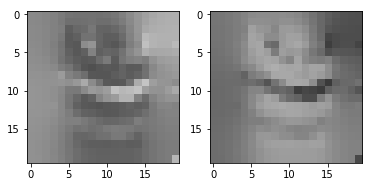

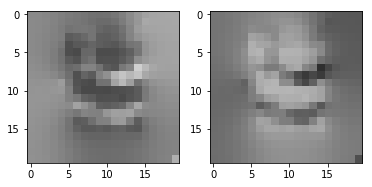

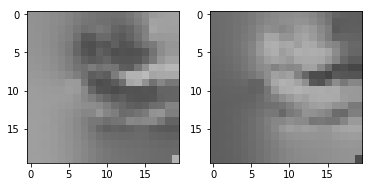

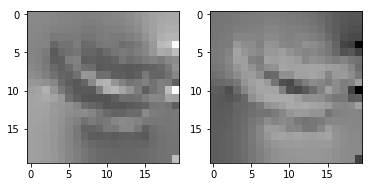

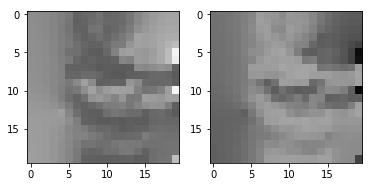

In [13]:
def do():
    for idx in (4, 459, 578, 1079, 553):
        do_one_case(idx)
do()